# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 15 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Докукин".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

В k-means находим такое разбиение на $K$ кластеров, чтобы минизировать
$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2 \rightarrow \min\limits_C $$
$$\mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n$$

E: принадлежность объектов кластерам
$$C_k = \{x_n : ||x_n - \mu_k||^2 \leq ||x_n - \mu_l||^2 \quad \forall l \neq k \} $$
Функционал не увеличивается, так как при постоянном положении центров кластеров выбираются не менее оптимальные (в смысле расстояний до центров) принадлежности точек кластерам.

M: пересчет положений центров
$$\mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n$$
Функционал не увеличивается, так как при постоянной принадлежности точек кластерам выбираются не менее оптимальные (в смысле расстояний до центров) положения центров кластеров.

Так как и на E, и на M шаге функционал не увеличивается, то и в целом он не будет увеличиваться.

Так как всего возможно $k^N$ разбиений $N$ объектов на $k$ кластеров и на каждом шаге алгоритм либо находит новое, более оптимальное разбиение, либо останавливается, то возможно сделать не более чем $k^N$ шагов до остановки.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Если правдоподие ограничено, то EM алгоритм сходится к стационарной точке. Это следует из того, что с каждым шагом правдоподобие не уменьшается. (дальше аналогично теореме Вейерштрасса)

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

single: пусть $d_{\min}(U, S) > d_{\min}(V, S)$, тогда получим $d_{\min}(U \cup V, S) \equiv d_{\min}(V, S) =  \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S) $ - верно.
аналогично доказывается для случая $d_{\min}(U, S) < d_{\min}(V, S)$.

complete: пусть $d_{\max}(U, S) > d_{\max}(V, S)$, тогда получим $d_{\max}(U \cup V, S) \equiv d_{\max}(U, S) =  \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} d_{\max}(U, S) - \frac{1}{2} d_{\max}(V, S) $ - верно.
аналогично доказывается для случая $d_{\max}(U, S) < d_{\max}(V, S)$.

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """

    def __init__(self, n_clusters=2, linkage='single', **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """

        if n_clusters > 0:
            self.n_clusters = n_clusters
        else:
            str_ = 'n_clusters should pe positive'
            raise RuntimeError(str_)

        self.linkages = ('single', 'complete', 'average')

        if linkage in self.linkages:
            self.linkage = linkage
        else:
            str_ = 'Only '
            for link in self.linkages:
                str_ += link + ', '
            str_ = str_[:-2] + ' are defined in Clustering'
            raise RuntimeError(str_)

        self.b = 0
        self.c = 0

        if self.linkage == 'single':
            self.ai = 0.5
            self.aj = 0.5
            self.c = -0.5

        if self.linkage == 'complete':
            self.ai = 0.5
            self.aj = 0.5
            self.c = 0.5

        return

    def euclidean_distance(self, X, Y):
        x_sq = (X ** 2).sum(axis=1).T
        y_sq = (Y ** 2).sum(axis=0)
        xy = X @ Y.T
        return x_sq - 2 * xy + y_sq

    def min_sorted(self, pos_min):
        if pos_min[0] < pos_min[1]:
            return pos_min[0], pos_min[1]
        else:
            return pos_min[1], pos_min[0]

    def distance(self, n1, n2):
        # в данной задаче все b=0 и d_ij не нужен
        # d_ij = np.full(self.x_len, self.matrix[n1, n2])

        d_ik = self.matrix[n1]
        d_jk = self.matrix[n2]

        if self.linkage == 'average':
            size_i = self.sizes[n1]
            size_j = self.sizes[n2]
            tot_size = size_i + size_j
            self.ai = size_i / tot_size
            self.aj = size_j / tot_size

        res = self.ai * d_ik + self.aj * d_jk + self.c * np.absolute(d_ik - d_jk)

        # для single linkage (расстояние с самим собой должно быть не 0)
        res[n1] = self.NAN_value

        return res

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        self.n_steps = self.x_len - self.n_clusters
        self.labels_ = np.arange(self.x_len)
        self.sizes = np.full(self.x_len, 1)

        self.matrix = np.empty((self.x_len, self.x_len))
        for i in range(self.x_len):
            self.matrix[i] = self.euclidean_distance(x, x[i])
        self.NAN_value = self.matrix.max() * 10000
        np.fill_diagonal(self.matrix, self.NAN_value)

        # надо бы избавиться от машинных нулей
        self.matrix[np.where(self.matrix < 0.00000001)] = 0

        self.NAN_array = np.full(self.x_len, self.NAN_value)

        for _ in range(self.n_steps):
            pos_min = np.unravel_index(self.matrix.argmin(), self.matrix.shape)
            n1, n2 = self.min_sorted(pos_min)
            dist = self.distance(n1, n2)
            self.matrix[:, n1] = dist
            self.matrix[n1, :] = dist
            self.matrix[:, n2] = self.NAN_array
            self.matrix[n2, :] = self.NAN_array
            self.sizes[n1] += self.sizes[n2]
            self.labels_[n2] = self.labels_[n1]

        for i in range(self.x_len):
            if self.labels_[i] != i:
                self.labels_[i] = self.labels_[self.labels_[i]]

        labels_dict = {}
        for i in range(self.x_len):
            if self.labels_[i] in labels_dict.keys():
                self.labels_[i] = labels_dict[self.labels_[i]]
            else:
                size_cur = len(labels_dict.keys())
                labels_dict[self.labels_[i]] = size_cur
                self.labels_[i] = size_cur

        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.labels_    

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

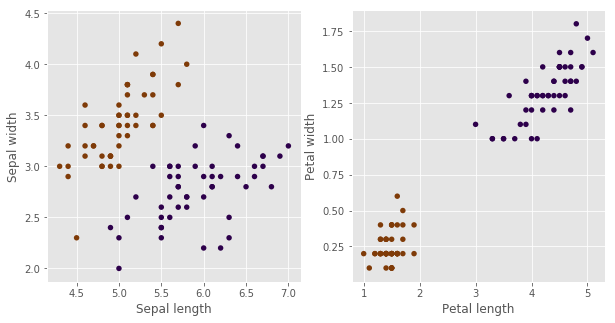

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [16]:
%%time
pred_iris = Clustering().fit_predict(x_iris)
#pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00
Wall time: 8 ms


In [17]:
%%time
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.004000186920166016. AGGL score 1.0. AGGL time 0.0
Wall time: 6 ms


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
# Место для Вашего кластерного анализа

In [8]:
data = pd.read_csv('WDI_csv/WDIData.csv')
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


Преобразуем названия стран и индикаторов в текст, сохранив преобразования как словари.

In [9]:
sc = StandardScaler()
le = LabelEncoder()

In [10]:
data['Country Name'] = le.fit_transform(data['Country Name'])
le_countries_map = dict(zip(le.transform(le.classes_), le.classes_))
for key in le_countries_map.keys():
    print('{}: {}'.format(key, le_countries_map[key]))

data['Indicator Name'] = le.fit_transform(data['Indicator Name'])
le_indicators_map = dict(zip(le.transform(le.classes_), le.classes_))
for key in le_indicators_map.keys():
    print('{}: {}'.format(key, le_indicators_map[key]))

data.head(5)

0: Afghanistan
1: Albania
2: Algeria
3: American Samoa
4: Andorra
5: Angola
6: Antigua and Barbuda
7: Arab World
8: Argentina
9: Armenia
10: Aruba
11: Australia
12: Austria
13: Azerbaijan
14: Bahamas, The
15: Bahrain
16: Bangladesh
17: Barbados
18: Belarus
19: Belgium
20: Belize
21: Benin
22: Bermuda
23: Bhutan
24: Bolivia
25: Bosnia and Herzegovina
26: Botswana
27: Brazil
28: British Virgin Islands
29: Brunei Darussalam
30: Bulgaria
31: Burkina Faso
32: Burundi
33: Cabo Verde
34: Cambodia
35: Cameroon
36: Canada
37: Caribbean small states
38: Cayman Islands
39: Central African Republic
40: Central Europe and the Baltics
41: Chad
42: Channel Islands
43: Chile
44: China
45: Colombia
46: Comoros
47: Congo, Dem. Rep.
48: Congo, Rep.
49: Costa Rica
50: Cote d'Ivoire
51: Croatia
52: Cuba
53: Curacao
54: Cyprus
55: Czech Republic
56: Denmark
57: Djibouti
58: Dominica
59: Dominican Republic
60: Early-demographic dividend
61: East Asia & Pacific
62: East Asia & Pacific (IDA & IBRD countries)
6

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,7,ARB,0,PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,ARB,1,PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,ARB,3,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,7,ARB,4,EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,7,ARB,5,EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


Видим, что у нас 264 страны и 1600 показателей.

In [11]:
data.drop(['Country Code', 'Indicator Code', 'Unnamed: 62'], inplace=True, axis=1)
data.head()

,Country Name,Indicator Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.243897,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN
3,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.432827,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN
4,7,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.402277,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN


In [12]:
data_tmp = data.copy()
data_tmp.fillna(value=0, inplace=True)

years = range(1960, 2018)
years_names = [str(i) for i in years]

for year in years_names:
    cur_data = np.zeros((264, 1600))
    this_year_data = data_tmp[['Country Name', 'Indicator Name', year]]

    for i in range(264):
        cur_data[i] = this_year_data[this_year_data['Country Name'] == i][year]

    min_ = cur_data.min().min()
    if min_ <= 0:
        cur_data -= (min_ - 100)
    cur_data = np.log(cur_data)
    cur_data = sc.fit_transform(cur_data)

    n_clusters = 10
    # мой алгоритм почему-то выдает странные результаты
    # сливает почти все кластеры в 1
    # result = Clustering(n_clusters=n_clusters).fit_predict(cur_data)
    # поэтому использую sklearn вариант
    sklearn_aggl = AgglomerativeClustering(n_clusters=n_clusters)
    result = sklearn_aggl.fit_predict(cur_data)

    clusters = {}
    for i in range(n_clusters):
        clusters[i] = []

    for i, res in enumerate(result):
        clusters[res].append(le_countries_map[i])

    print(year)
    for i in range(n_clusters):
        print(clusters[i])
    print()

1960
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Euro area', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fiji', 'Finland', 'F

1962
['Afghanistan', 'Argentina', 'Bangladesh', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Dominican Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eswatini', 'Fiji', 'Fragile and conflict affected situations', 'French Polynesia', 'Gabon', 'Ghana', 'Guatemala', 'Guyana', 'Heavily indebted poor countries (HIPC)', 'Honduras', 'Hong Kong SAR, China', 'IDA only', 'IDA total', 'India', 'Israel', 'Jamaica', 'Jordan', 'Kenya', 'Korea, Rep.', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 

1964
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fiji', 'F

1966
['Argentina', 'Benin', 'Bolivia', 'Brazil', 'Burkina Faso', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Dominican Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Europe & Central Asia', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Kenya', 'Korea, Rep.', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Lower middle income', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Nicaragua', 'Niger', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Senegal', 'Singapore', 'Somalia', 'South Asia', 'South Asia (IDA & IBRD)', 'Sri Lanka', 'Thailand', 'Togo', 'Tunisia', 'Up

1968
['Early-demographic dividend', 'IBRD only', 'IDA & IBRD total', 'Low & middle income', 'Middle income', 'World']
['Austria', 'Belgium', 'Denmark', 'Euro area', 'Europe & Central Asia', 'European Union', 'Finland', 'France', 'Germany', 'Iceland', 'Italy', 'Luxembourg', 'Netherlands', 'North America', 'Norway', 'Sweden', 'Switzerland']
['United States']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Re

1970
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 

1972
['IBRD only', 'IDA & IBRD total', 'IDA only', 'India', 'Low income', 'Lower middle income', 'South Asia', 'Sub-Saharan Africa (excluding high income)']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republ

1974
['Germany', 'North America', 'United Kingdom', 'United States']
['Albania', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Barbados', 'Belarus', 'Belize', 'Bermuda', 'Bhutan', 'Bosnia and Herzegovina', 'British Virgin Islands', 'Bulgaria', 'Cabo Verde', 'Cambodia', 'Caribbean small states', 'Cayman Islands', 'Central Europe and the Baltics', 'Channel Islands', 'Comoros', 'Croatia', 'Curacao', 'Czech Republic', 'Djibouti', 'Dominica', 'Eritrea', 'Estonia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'Faroe Islands', 'French Polynesia', 'Georgia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Hungary', 'IDA blend', 'Isle of Man', 'Kazakhstan', 'Korea, Dem. People’s Rep.', 'Kosovo', 'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Macao SAR, China', 'Macedonia, FYR', 'Maldives', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Moldova', 

1976
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvad

1978
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Euro area', 'Europe & Central Asi

1980
['Indonesia', 'Iran, Islamic Rep.', 'Korea, Rep.']
['China', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA only', 'IDA total', 'India', 'Late-demographic dividend', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Pre-demographic dividend', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['High income', 'OECD members', 'Post-demographic dividend', 'World']
['Low & middle income', 'Middle income']
['American Samoa', 'Andorra', 'Angola', 'Armenia', 'Aruba', 'Azerbaijan', 'Barbados', 'Belarus', 'Bermuda', 'Bhutan', 'Bosnia and Herzegovina', 'British Virgin Islands', 'Cambodia', 'Cayman Islands', 'Channel Islands', 'Croatia'

1982
['High income', 'OECD members', 'Post-demographic dividend', 'World']
['Arab World', 'Caribbean small states', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)', 'Middle East & North Africa (excluding high income)', 'Other small states', 'Pacific island small states', 'Pre-demographic dividend', 'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high inco

1984
['High income', 'OECD members', 'Post-demographic dividend', 'World']
['Indonesia', 'Iran, Islamic Rep.', 'Korea, Rep.']
['Algeria', 'Arab World', 'Argentina', 'Bahrain', 'Bangladesh', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Caribbean small states', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Cyprus', 'Dominican Republic', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Eswatini', 'Ethiopia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'Fiji', 'Fragile and conflict affected situations', 'Gabon', 'Gambia, The', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heavily indebted po

1986
['American Samoa', 'Andorra', 'Armenia', 'Aruba', 'Azerbaijan', 'Barbados', 'Belarus', 'Bermuda', 'Bosnia and Herzegovina', 'British Virgin Islands', 'Cambodia', 'Cayman Islands', 'Channel Islands', 'Croatia', 'Curacao', 'Czech Republic', 'Dominica', 'Eritrea', 'Estonia', 'Faroe Islands', 'French Polynesia', 'Georgia', 'Gibraltar', 'Greenland', 'Guam', 'Isle of Man', 'Kazakhstan', 'Korea, Dem. People’s Rep.', 'Kosovo', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Macedonia, FYR', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Moldova', 'Monaco', 'Montenegro', 'Namibia', 'Nauru', 'New Caledonia', 'Northern Mariana Islands', 'Not classified', 'Palau', 'Puerto Rico', 'Russian Federation', 'San Marino', 'Serbia', 'Sint Maarten (Dutch part)', 'Slovak Republic', 'Slovenia', 'South Sudan', 'St. Kitts and Nevis', 'St. Martin (French part)', 'Tajikistan', 'Timor-Leste', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Ukraine', 'Uzbekistan', 'Virgin Islands (

1988
['High income', 'OECD members', 'Post-demographic dividend', 'World']
['Indonesia', 'Iran, Islamic Rep.', 'Korea, Rep.']
['Arab World', 'Central Europe and the Baltics', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)', 'Middle East & North Africa (excluding high income)', 'Other small states', 'Pre-demographic dividend', 'Small states', 'South Asia', 'South As

1990
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Czech Republic', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'Faroe Islands', 'Fiji', 'Fragile and conflict affected situ

1992
['Indonesia', 'Iran, Islamic Rep.', 'Korea, Rep.']
['Brazil', 'Latin America & Caribbean (excluding high income)', 'Lower middle income', 'Mexico', 'Upper middle income']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equa

1994
['Low & middle income', 'Middle income', 'Upper middle income']
['Indonesia', 'Iran, Islamic Rep.', 'Korea, Rep.', 'Vietnam']
['High income', 'OECD members', 'Post-demographic dividend']
['Brazil', 'China', 'East Asia & Pacific (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'IDA only', 'IDA total', 'India', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Mexico', 'Pre-demographic dividend', 'South Asia', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Buru

1996
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'French Polynesia', 'Gabon', 'Gambia, The', 'Georgia', 'Ghana', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary', 'IDA blend', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, Dem. People’s Rep.', 'Kuwait', 'Kyrgyz Republ

1998
['Argentina', 'Brazil', 'China', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Europe & Central Asia (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA only', 'IDA total', 'India', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Mexico', 'Pre-demographic dividend', 'Russian Federation', 'South Asia', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['Low & middle income', 'Middle income', 'Upper middle income']
['High income', 'OECD members', 'Post-demographic dividend']
['Australia', 'Austria', 'Bahamas, The', 'Bahrain', 'Belgium', 'Brunei Darussalam', 'Canada', 

2000
['Iran, Islamic Rep.', 'Japan', 'Korea, Rep.', 'Vietnam']
['Argentina', 'Brazil', 'China', 'Europe & Central Asia (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'IDA only', 'IDA total', 'India', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low income', 'Mexico', 'Pre-demographic dividend', 'Russian Federation', 'South Asia', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)', 'Turkey']
['East Asia & Pacific (excluding high income)', 'Lower middle income', 'Upper middle income']
['Low & middle income', 'Middle income']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswan

2002
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Centr

2004
['Indonesia', 'Japan', 'Korea, Rep.', 'Vietnam']
['Brazil', 'China', 'East Asia & Pacific (excluding high income)', 'Europe & Central Asia (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'IDA only', 'IDA total', 'India', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Pre-demographic dividend', 'Russian Federation', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['High income', 'OECD members', 'Post-demographic dividend']
['Low & middle income', 'Middle income', 'Upper middle income']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Bulgaria', 'Burkina F

2006
['Low & middle income', 'Middle income', 'Upper middle income']
['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Brunei Darussalam', 'Canada', 'China', 'Denmark', 'Europe & Central Asia (excluding high income)', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Kuwait', 'Latin America & Caribbean (excluding high income)', 'Luxembourg', 'Mexico', 'Netherlands', 'Norway', 'Qatar', 'Russian Federation', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom']
['Indonesia', 'Korea, Rep.', 'Vietnam']
['Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'European Union', 'IBRD only', 'IDA & IBRD total', 'Late-demographic dividend', 'North America']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Aruba', '

2008
['Brazil', 'China', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'IBRD only', 'IDA & IBRD total', 'India', 'Late-demographic dividend', 'Latin America & Caribbean (excluding high income)', 'North America', 'Russian Federation', 'South Asia']
['Low & middle income', 'Middle income', 'Upper middle income']
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Caribbean small states', 'Cayman Islands', 'Central African Republic', 'Central Europe a

2010
['China', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'European Union', 'High income', 'IBRD only', 'IDA & IBRD total', 'Late-demographic dividend', 'North America', 'OECD members', 'Post-demographic dividend']
['Algeria', 'Antigua and Barbuda', 'Arab World', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Barbados', 'Belize', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Cabo Verde', 'Caribbean small states', 'Central Europe and the Baltics', 'Channel Islands', 'Chile', 'Cuba', 'Dominica', 'Early-demographic dividend', 'Equatorial Guinea', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'Fiji', 'French Polynesia', 'Grenada', 'Guam', 'Guyana', 'Hong Kong SAR, China', 'IDA blend', 'India', 'Iraq', 'Jamaica', 'Kiribati', 'Korea, Dem. People’s Rep.', 'Kuwait', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding h

2012
['Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Pre-demographic dividend', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['Low & middle income', 'Middle income', 'Upper middle income']
['China', 'United States']
['Indonesia', 'Iran, Islamic Rep.', 'Vietnam']
['Albania', 'Algeria', 'Arab World', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahamas, The', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Cabo Verde', 'Cambodia', 'Caribbean small states', 'Chile', 'Colombia', 'Cos

2014
['Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Least developed countries: UN classification', 'Low income', 'Pre-demographic dividend', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['Argentina', 'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei Darussalam', 'Canada', 'Central Europe and the Baltics', 'Colombia', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong SAR, China', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, Rep.', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg', 'Macao SAR, China', 'Malta'

2016
['China', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'European Union', 'High income', 'IBRD only', 'IDA & IBRD total', 'Late-demographic dividend', 'North America', 'OECD members', 'Post-demographic dividend']
['Indonesia', 'Iran, Islamic Rep.', 'Vietnam']
['Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IDA only', 'IDA total', 'Least developed countries: UN classification', 'Low income', 'Pre-demographic dividend', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)']
['Lower middle income', 'Upper middle income']
['Australia', 'Austria', 'Bahamas, The', 'Bahrain', 'Belgium', 'Brunei Darussalam', 'Bulgaria', 'Canada', 'Central Europe and the Baltics', 'Chile', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Europe & Central Asia (I

Чего-то получилось. В некоторых местах похоже на деление по уровню дохода, но есть и кластеры прямо противоречащие этому предположению и чего конкретно получилось не особо понятно.

In [13]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Задачи деления объектов на группы, поиск того, какие признаки играют существенную роль при таком делении.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

kmeans: одновременно и преимуществом и недостатком является случайность алгоритма.
* преимущества: простота, большая вариативность в виде модификаций
* недостатки: сферические кластеры, нужно задавать число кластеров заранее

dbscan: 
* преимущества: произвольная форма кластеров, сам определяет число кластеров, устойчив к выбросам
* недостатки: плохо работает при различных плотностях кластеров 

агломеративная кластеризация: 
* преимущества: произвольная форма кластеров, получаем сразу все дерево решения и можем из него быстро определить какое число кластеров будет оптимальным, наглядность
* недостатки: большие затраты по памяти и времени выполнения 

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

В EM вводятся скрытые переменные. Если их вид очевиден, либо очевидно, что таких переменных нет, то применять алгоритм не стоит.

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

Проклятием размерности страдают все алгоритмы, в том числе и алгоритмы кластеризации. Хотя, для аггломеративной кластеризации небольшое увеличение количества фичей не сказывается катастрофическим образом на скорости работы. Решения стандартные: удаление явно лишних фичей, PCA, t-SNE. 

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Во-первых, если нам не повезло и есть документы на разных языках , то нужно разбить по языкам. Далее самое простое решение, которое можно попробовать - сгруппировать (например, k-means) по частоте встречающихся токенов и раздать получившимся кластерам вручную темы, проанализировав какие токены наиболее в них популярны. 

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Можно учесть разметку данных при раздаче тем получившимся кластерам. При необходимости использования такого подхода надо будет внимательно ознакомиться с литературой по данной тематике.  

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***